In [7]:
import pandas as pd

import numpy as np

import h5py

import glob

import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf


In [8]:
import os

im_path_tr = '../../../Landslide4Sense/Data/TrainData/img/'
ma_path_tr = "../../../Landslide4Sense/Data/TrainData/mask"


# im_path_te = "Data/TestData/img"
# ma_path_te = "Data/TestData/img"

# im_path_va = "Data/ValidData/img"
# ma_path_va = "Data/ValidData/img"

print(os.path.isdir(im_path_tr))
print(os.path.isfile(im_path_tr+'/image_1.h5'))

True
True


In [9]:
# Testing the dataset 

path_single = im_path_tr+"/image_1.h5"
path_single_mask = ma_path_tr+'/mask_1.h5'

Available keys in the HDF5 file: ['img']
Input data shape: (128, 128, 14)


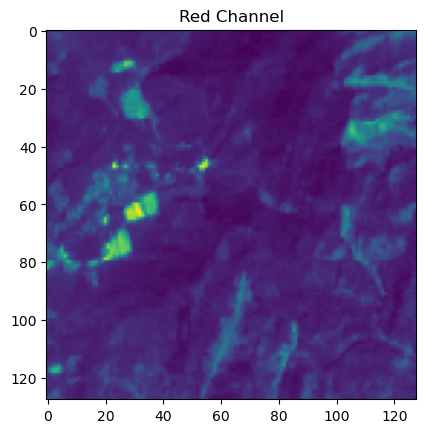

NameError: name 'Band1600nm' is not defined

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File paths (ensure these are correct for Kaggle)
path_single = im_path_tr+"/image_1.h5"
path_single_mask = ma_path_tr+'/mask_1.h5'

f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file
with h5py.File(path_single, 'r') as hdf:
    # Print keys in the HDF5 file
    ls = list(hdf.keys())
    print("Available keys in the HDF5 file:", ls)
    
    # Check if 'img' key exists
    if 'img' not in ls:
        raise KeyError("'img' key not found in HDF5 file")
    
    # Load the image data
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)
    
    # Check the shape to avoid indexing errors
    if data.shape[2] < 14:
        raise ValueError("The data has fewer than 14 channels. Shape:", data.shape)

    # Display a sample image (e.g., Red channel)
    plt.imshow(data[:, :, 3])  # Red channel (adjust as needed)
    plt.title("Red Channel")
    plt.show()

    # Extract specific bands for NDVI calculation
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_swir = data[:, :, 10]

    MSI = Band1600nm / Band820nm
    

    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red), where=(data_nir + data_red) != 0)
    
    # Store NDVI and other bands in f_data
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("data_ndvi shape:", data_ndvi.shape, "f_data shape:", f_data.shape)
    
    # Plot NDVI
    plt.imshow(data_ndvi, cmap='viridis')
    plt.title("NDVI")
    plt.show()

ls ['mask']
input data shape: (128, 128)


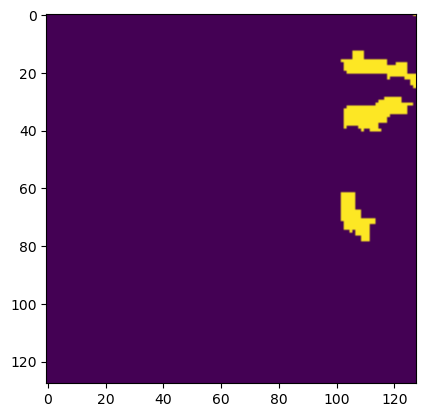

In [11]:
with h5py.File(path_single_mask) as hdf:

    ls = list(hdf.keys())

    print("ls", ls)

    data = np.array(hdf.get('mask'))

    print("input data shape:", data.shape)

    plt.imshow(data)

In [12]:


TRAIN_PATH = r"/kaggle/input/landslide4sense/TrainData/img/*.h5"

TRAIN_MASK = r'/kaggle/input/landslide4sense/TrainData/mask/*.h5'

TRAIN_PATH = im_path_tr+r"/*.h5"

TRAIN_MASK = ma_path_tr+r"/*.h5"



TRAIN_XX = np.zeros((3799, 128, 128, 10))

TRAIN_YY = np.zeros((3799, 128, 128, 1))

all_train = sorted(glob.glob(TRAIN_PATH))

all_mask = sorted(glob.glob(TRAIN_MASK))




Train with RGB, NDVI, DEM, and Slop

In [13]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else:
    print("No GPUs Available")


GPUs Available: 1
GPU Name: /physical_device:GPU:0


In [14]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):

    print(i, img, mask)

    with h5py.File(img) as hdf:

        ls = list(hdf.keys())

        data = np.array(hdf.get('img'))



        # assign 0 for the nan value

        data[np.isnan(data)] = 0.000001



        # to normalize the data 

        mid_rgb = data[:, :, 1:4].max() / 2.0

        mid_4 = data[:, :, 4].max() / 2.0

        mid_5 = data[:, :, 5].max() / 2.0

        mid_6 = data[:, :, 6].max() / 2.0

        mid_7 = data[:, :, 7].max() / 2.0

        mid_8 = data[:, :, 8].max() / 2.0

        mid_slope = data[:, :, 12].max() / 2.0

        mid_elevation = data[:, :, 13].max() / 2.0



        # # ndvi calculation

        # data_red = data[:, :, 3]

        # data_nir = data[:, :, 7]

        # data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        

        # final array

        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED

        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN

        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE

        TRAIN_XX[i, :, :, 3] = 1 - data[:, :, 4]/ mid_5

        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 5]/ mid_5 #data_ndvi #NDVI

        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 6]/ mid_5

        TRAIN_XX[i, :, :, 6] = 1 - data[:, :, 7]/ mid_5

        TRAIN_XX[i, :, :, 7] = 1 - data[:, :, 8]/ mid_5

        TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE

        TRAIN_XX[i, :, :, 9] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

    

    

    with h5py.File(mask) as hdf:

        ls = list(hdf.keys())

        data=np.array(hdf.get('mask'))

        TRAIN_YY[i, :, :, 0] = data

    

0 ../../../Landslide4Sense/Data/TrainData/img/image_1.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1.h5
1 ../../../Landslide4Sense/Data/TrainData/img/image_10.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_10.h5
2 ../../../Landslide4Sense/Data/TrainData/img/image_100.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_100.h5
3 ../../../Landslide4Sense/Data/TrainData/img/image_1000.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1000.h5
4 ../../../Landslide4Sense/Data/TrainData/img/image_1001.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1001.h5
5 ../../../Landslide4Sense/Data/TrainData/img/image_1002.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1002.h5
6 ../../../Landslide4Sense/Data/TrainData/img/image_1003.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1003.h5
7 ../../../Landslide4Sense/Data/TrainData/img/image_1004.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_1004.h5
8 ../../../Landslide4Sense/Data/TrainData/img/image_1005.h5 ../../..

/var/folders/7p/skyzq__54w10q_m2tnsc0grh0000gn/T/ipykernel_55647/4058525223.py:67: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE


1714 ../../../Landslide4Sense/Data/TrainData/img/image_2541.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2541.h5
1715 ../../../Landslide4Sense/Data/TrainData/img/image_2542.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2542.h5
1716 ../../../Landslide4Sense/Data/TrainData/img/image_2543.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2543.h5
1717 ../../../Landslide4Sense/Data/TrainData/img/image_2544.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2544.h5
1718 ../../../Landslide4Sense/Data/TrainData/img/image_2545.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2545.h5
1719 ../../../Landslide4Sense/Data/TrainData/img/image_2546.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2546.h5
1720 ../../../Landslide4Sense/Data/TrainData/img/image_2547.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2547.h5
1721 ../../../Landslide4Sense/Data/TrainData/img/image_2548.h5 ../../../Landslide4Sense/Data/TrainData/mask/mask_2548.h5
1722 ../../../Landslide4Sense/Da

Testing min, max values in train data¶


In [15]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()

TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-7.072144312350469 1.0 0.0 1.0


In [16]:
def dice_loss(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)

  y_pred = tf.math.sigmoid(y_pred)

  numerator = 2 * tf.reduce_sum(y_true * y_pred)

  denominator = tf.reduce_sum(y_true + y_pred)



  return 1 - numerator / denominator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7836734693877552].


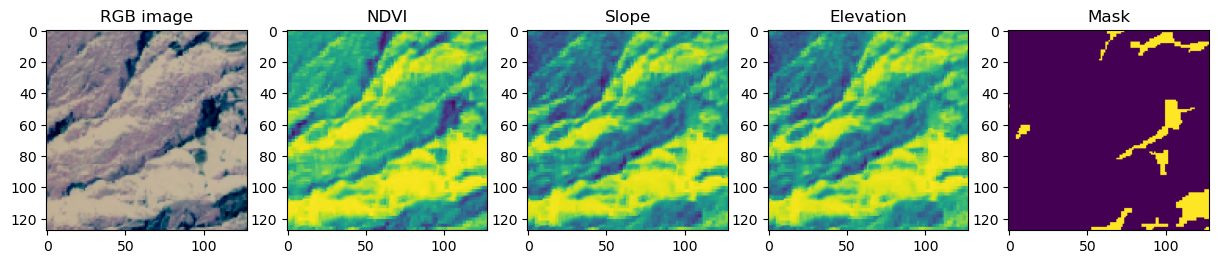

In [17]:
img=234

fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))





ax1.set_title("RGB image")

ax2.set_title("NDVI")

ax3.set_title("Slope")

ax4.set_title("Elevation")

ax5.set_title("Mask")

ax1.imshow(TRAIN_XX[img, :, :, 0:3])

ax2.imshow(TRAIN_XX[img, :, :, 3])

ax3.imshow(TRAIN_XX[img, :, :, 4])

ax4.imshow(TRAIN_XX[img, :, :, 5])

ax5.imshow(TRAIN_YY[img, :, :, 0])

In [18]:
from sklearn.model_selection import train_test_split



# Split the data

x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6317073170731707].


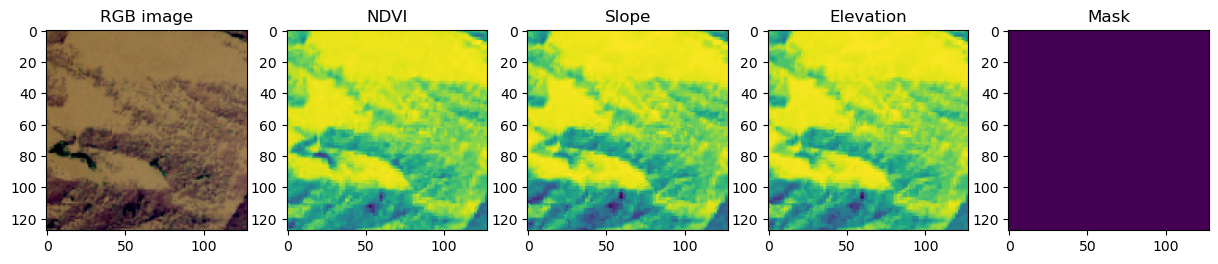

In [19]:
img=1545

fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))



ax1.set_title("RGB image")

ax2.set_title("NDVI")

ax3.set_title("Slope")

ax4.set_title("Elevation")

ax5.set_title("Mask")

ax1.imshow(x_train[img, :, :, 0:3])

ax2.imshow(x_train[img, :, :, 3])

ax3.imshow(x_train[img, :, :, 4])

ax4.imshow(x_train[img, :, :, 5])

ax5.imshow(y_train[img, :, :, 0])

In [20]:
x_train.shape, y_train.shape


((3039, 128, 128, 10), (3039, 128, 128, 1))

In [21]:
del TRAIN_XX

del TRAIN_YY

del all_train

del all_mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6317073170731707].


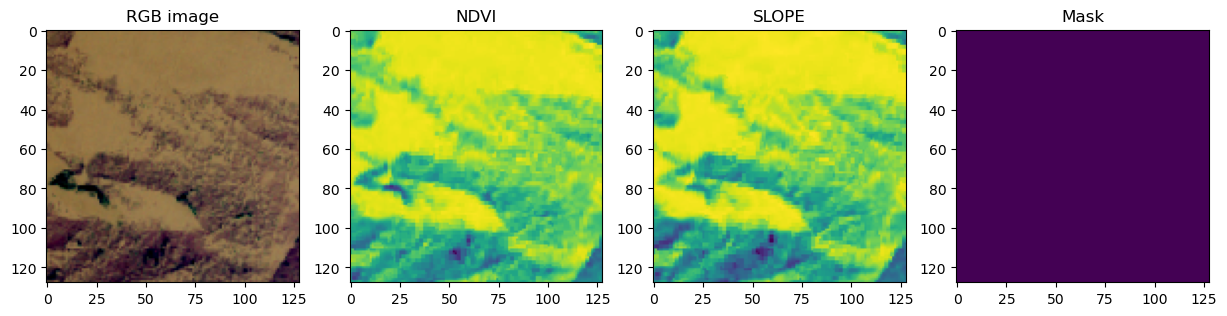

In [22]:
img=1545

fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))





ax1.set_title("RGB image")

ax2.set_title("NDVI")

ax3.set_title("SLOPE")

ax4.set_title("Mask")

ax1.imshow(x_train[img, :, :, 0:3])

ax2.imshow(x_train[img, :, :, 3])

ax3.imshow(x_train[img, :, :, 4])

ax4.imshow(y_train[img, :, :, 0])


## UNET MODEL

2025-03-14 08:44:40.680747: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-14 08:44:40.680810: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-14 08:44:40.680829: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-14 08:44:40.680858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-14 08:44:40.680877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


/Users/frankconway/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 10))
  warnings.warn(msg)
2025-03-14 08:44:44.803984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_f1_m improved from -inf to 0.17597, saving model to best_model10Chan.keras
190/190 - 28s - 148ms/step - accuracy: 0.9692 - f1_m: 0.0069 - loss: 0.0891 - precision_m: 0.2453 - recall_m: 0.0106 - val_accuracy: 0.9795 - val_f1_m: 0.1760 - val_loss: 0.0468 - val_precision_m: 0.8473 - val_recall_m: 0.0999
Epoch 2/10

Epoch 2: val_f1_m improved from 0.17597 to 0.58696, saving model to best_model10Chan.keras
190/190 - 20s - 103ms/step - accuracy: 0.9839 - f1_m: 0.5688 - loss: 0.0436 - precision_m: 0.7175 - recall_m: 0.5085 - val_accuracy: 0.9848 - val_f1_m: 0.5870 - val_loss: 0.0400 - val_precision_m: 0.7148 - val_recall_m: 0.5094
Epoch 3/10

Epoch 3: val_f1_m improved from 0.58696 to 0.60570, saving model to best_model10Chan.keras
190/190 - 19s - 101ms/step - accuracy: 0.9851 - f1_m: 0.6128 - loss: 0.0402 - precision_m: 0.7346 - recall_m: 0.5464 - val_accuracy: 0.9855 - val_f1_m: 0.6057 - val_loss: 0.0373 - val_precision_m: 0.7382 - val_recall_m: 0.5234
Epoch 4/10

Epoch 4: val

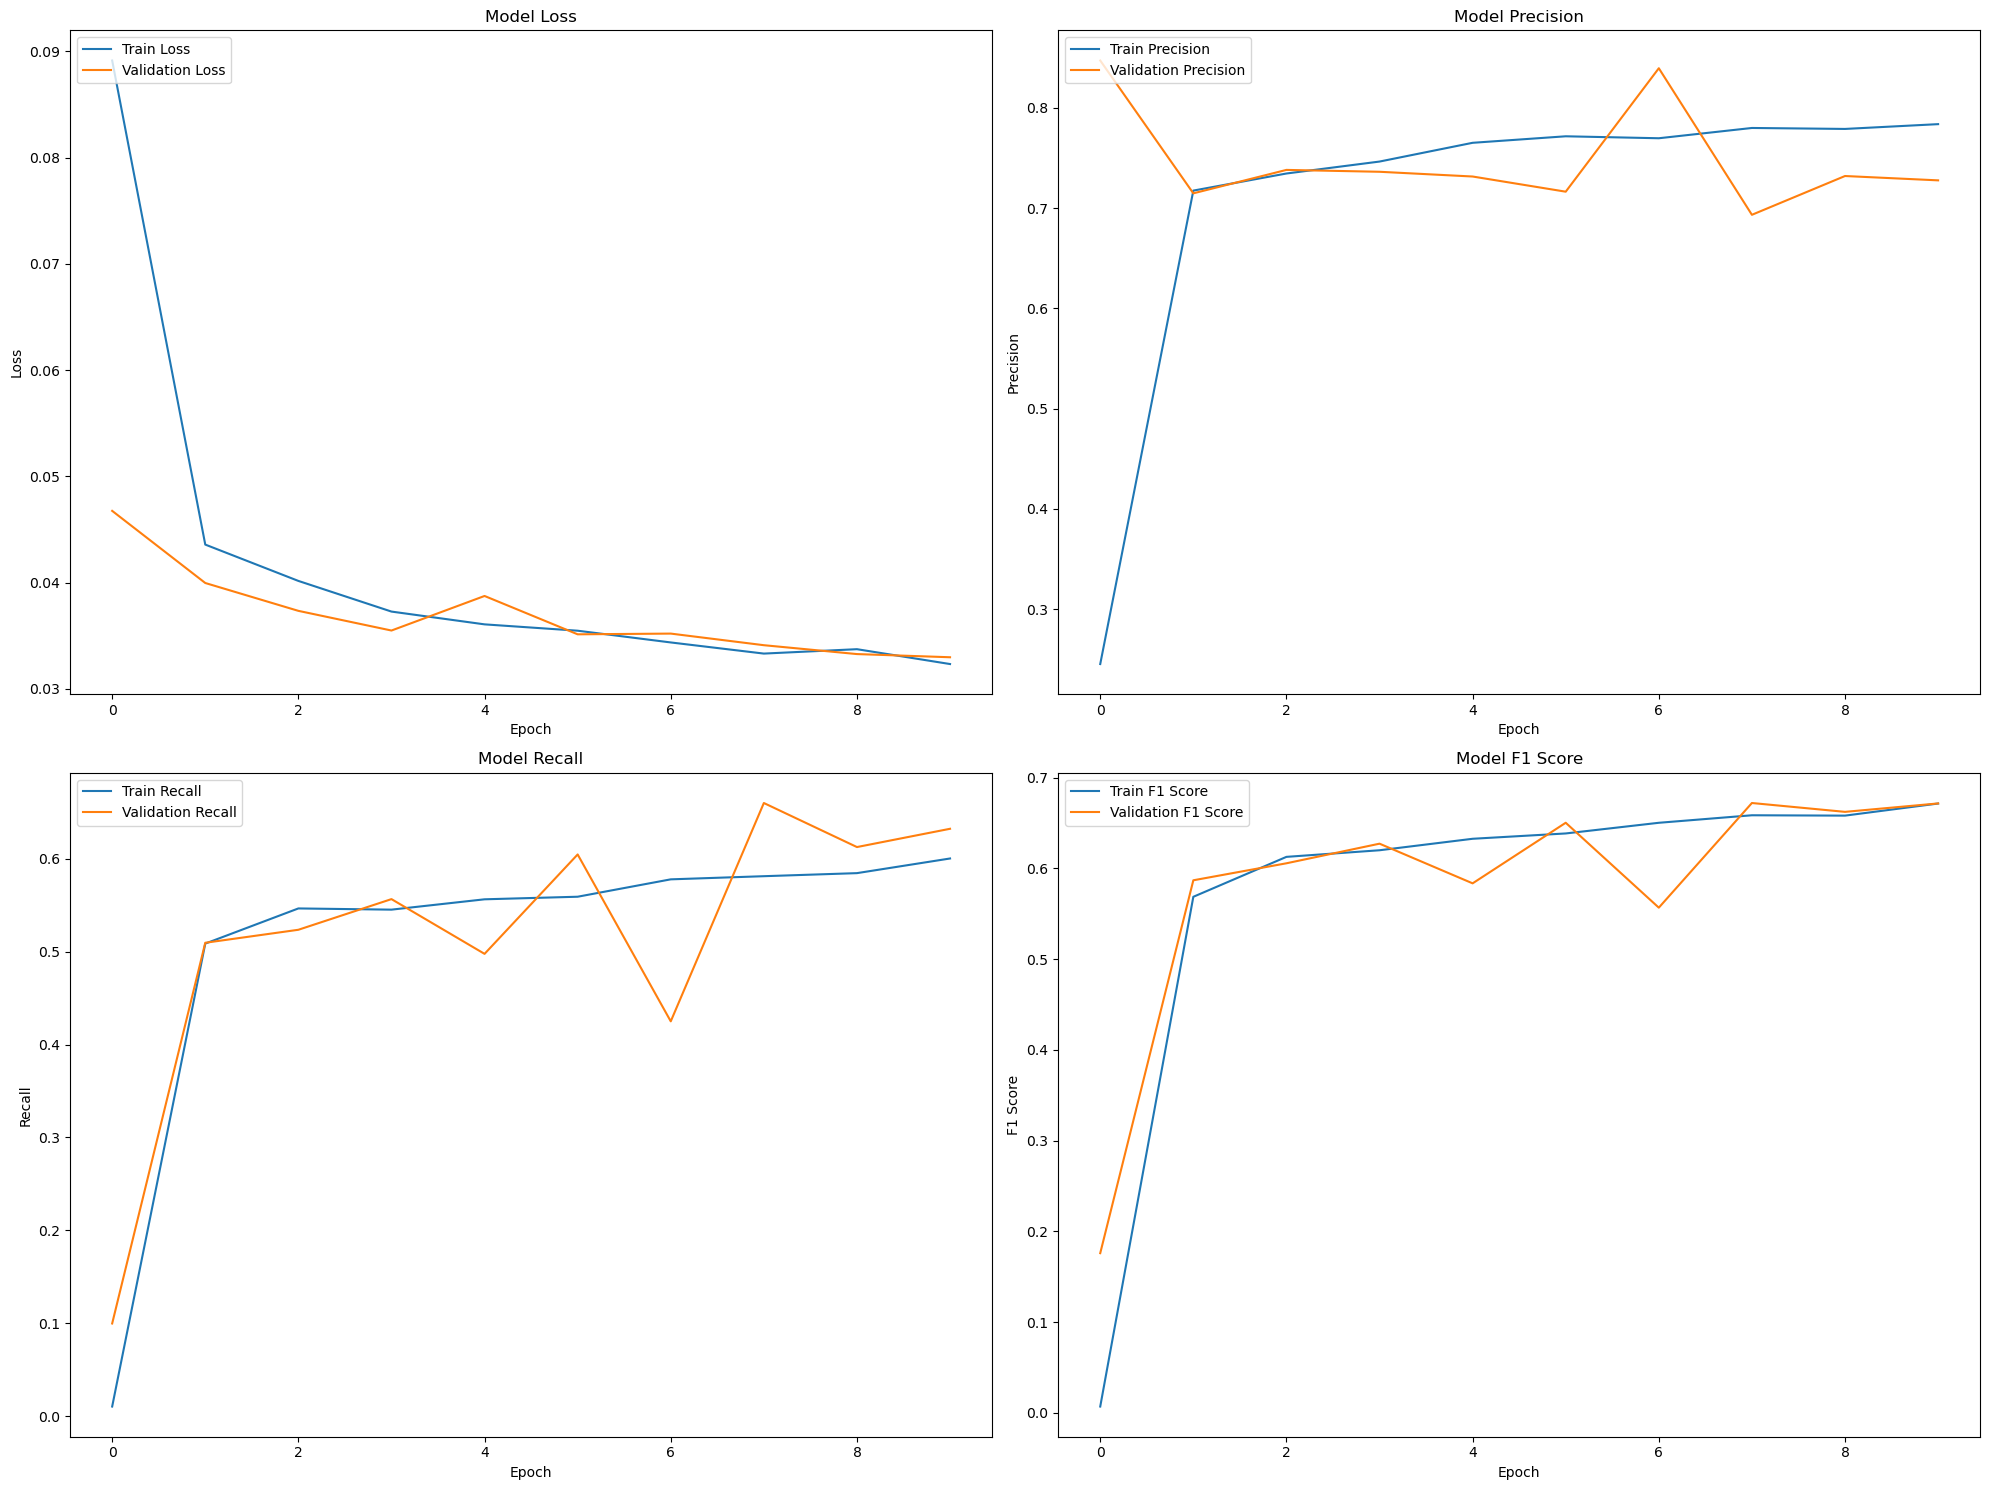

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Custom Metrics
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Define UNet Model
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding Path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

# Example Usage
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 10

# Define training and validation data (ensure data is preprocessed and normalized)
# x_train, y_train, x_valid, y_valid = ... (Load your datasets)

# Initialize and compile the model
model = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# Define Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "best_model10Chan.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max"
)
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_m", patience=10, verbose=1, mode="max"
)

callbacks = [earlyStopping, checkpointer]

# Train the model
history = model.fit(
    x_train, y_train, batch_size=16, epochs=10, verbose=2,
    validation_data=(x_valid, y_valid), callbacks=callbacks
)

# Save the final model
model.save("model_save10Chan.keras")

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

# Visualize Training History
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

ax11.plot(history.history['loss'], label='Train Loss')
ax11.plot(history.history['val_loss'], label='Validation Loss')
ax11.set_title('Model Loss')
ax11.set_ylabel('Loss')
ax11.set_xlabel('Epoch')
ax11.legend(loc='upper left')

ax12.plot(history.history['precision_m'], label='Train Precision')
ax12.plot(history.history['val_precision_m'], label='Validation Precision')
ax12.set_title('Model Precision')
ax12.set_ylabel('Precision')
ax12.set_xlabel('Epoch')
ax12.legend(loc='upper left')

ax13.plot(history.history['recall_m'], label='Train Recall')
ax13.plot(history.history['val_recall_m'], label='Validation Recall')
ax13.set_title('Model Recall')
ax13.set_ylabel('Recall')
ax13.set_xlabel('Epoch')
ax13.legend(loc='upper left')

ax14.plot(history.history['f1_m'], label='Train F1 Score')
ax14.plot(history.history['val_f1_m'], label='Validation F1 Score')
ax14.set_title('Model F1 Score')
ax14.set_ylabel('F1 Score')
ax14.set_xlabel('Epoch')
ax14.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

 4/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

/Users/frankconway/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 10))
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [26]:
np.savez_compressed("pred.npz", pred=pred_img, lables=y_valid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7579388855602157].


Text(0.5, 1.0, 'Training Image')

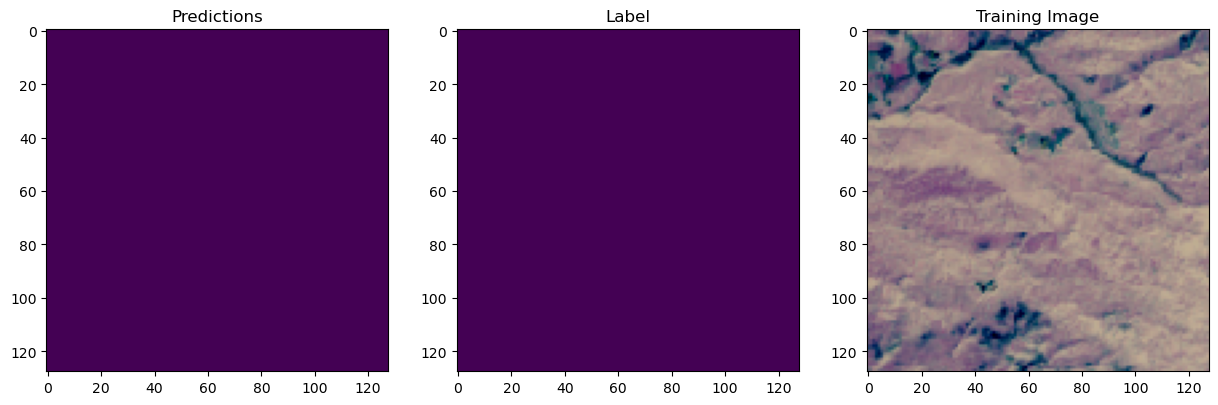

In [77]:
img = 100
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

## Validation

In [ ]:
validation_url = r'/content/gdrive/MyDrive/DL/landslide4Sense/data/validation/img/*.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

In [ ]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape